In [88]:
import pandas as pd
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [89]:
df = pd.read_json('data/unlabelled_recipies.json')

In [90]:
df['number_of_ingredients'] = df['ingredients'].apply(len)

In [91]:
# tokenize each ingredient
tokenizer = RegexpTokenizer(r'\w+')
df['tokenized_ingredients'] = df['ingredients'].apply(str)
df['tokenized_ingredients'] = df['tokenized_ingredients'].apply(tokenizer.tokenize)

In [92]:
df.iloc[0]

ingredients              [pepper, bacon, russet potatoes, sugar, onions...
number_of_ingredients                                                   11
tokenized_ingredients    [pepper, bacon, russet, potatoes, sugar, onion...
Name: 0, dtype: object

In [93]:
# remove numbers but not words with numbers
def remove_numbers(doc):
    return [token for token in doc if not token.isdigit()]
df['tokenized_ingredients'] = df['tokenized_ingredients'].apply(remove_numbers)

In [94]:
# Remove words that are only one character.
def remove_onechar_word(doc):
    return [token for token in doc if len(token) > 3]
df['tokenized_ingredients'] = df['tokenized_ingredients'].apply(remove_onechar_word)

In [95]:
# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(doc):
    return [lemmatizer.lemmatize(token) for token in doc]
df['tokenized_ingredients'] = df['tokenized_ingredients'].apply(lemmatize_tokens)

In [96]:
#Create Biagram & Trigram Models 
from gensim.models import Phrases
bigram = Phrases(df['tokenized_ingredients'], min_count=2)
trigram = Phrases(bigram[df['tokenized_ingredients']], min_count=2)

In [97]:
def get_bigrams_and_trigrams(doc):
    return trigram[doc]
    
df['tokenized_ingredients'] = df['tokenized_ingredients'].apply(get_bigrams_and_trigrams)

In [98]:
df['tokenized_ingredients'][:10]

0        [pepper, bacon, russet_potato, sugar, onion, g...
1        [carrot, leek, unsalted_butter, finely_chopped...
10       [orzo, garlic, heavy_cream, white, wine, spina...
100      [garlic, ginger, fish, sauce, chayotes, cookin...
1000     [onion, avocado, salt, coconut, cream, cumin, ...
10000    [salt, onion, salt, paprika, ground, cumin, di...
10001    [fennel_seed, sugar, cane, juice, thai_basil, ...
10002    [water, part_skim, ricotta, cheese, provolone,...
10003    [lemon, juice, salt, white, milk, yolk, unsalt...
10004    [sambal, ulek, brown, sugar, peeled, fresh, gi...
Name: tokenized_ingredients, dtype: object

In [99]:
df[df['number_of_ingredients']<=1]['tokenized_ingredients']

12200                   [water]
12457              [sushi_rice]
14807                  [butter]
2067                  [grained]
21177           [corn_tortilla]
23371            [plain_yogurt]
24568                  [phyllo]
27348         [spanish_chorizo]
31568         [unsalted_butter]
32133            [sticky, rice]
37773          [haricot, verts]
38426    [lemonade_concentrate]
39092             [cumin, seed]
39171          [cherry, tomato]
451                      [udon]
5162                   [butter]
5615          [unsalted_butter]
7875             [jasmine_rice]
9397      [dried, rice, noodle]
Name: tokenized_ingredients, dtype: object

In [100]:
# drop recipes with one ingredient
index_to_drop = df[df['number_of_ingredients']<=1].index
df.drop(index_to_drop, inplace=True)

In [101]:
# Create a dictionary representation of the recipe ingredients.
dictionary = Dictionary(df['tokenized_ingredients'])
dictionary.filter_extremes(no_below=50, no_above=0.5)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc['tokenized_ingredients']) for i, doc in df.iterrows()]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[0])

Number of unique tokens: 818
Number of documents: 39755
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [102]:
# Make a index to word dictionary.
temp = dictionary[0] # only to "load" the dictionary.
id2word = dictionary.id2token
id2word

{0: 'bacon',
 1: 'cheese',
 2: 'kimchi',
 3: 'olive',
 4: 'onion',
 5: 'russet_potato',
 6: 'scallion',
 7: 'shredded_cheddar',
 8: 'sugar',
 9: 'baking',
 10: 'broth',
 11: 'carrot',
 12: 'chicken',
 13: 'dried',
 14: 'finely_chopped',
 15: 'half_half',
 16: 'leaf',
 17: 'leek',
 18: 'potato',
 19: 'saffron_thread',
 20: 'thyme',
 21: 'unsalted_butter',
 22: 'water',
 23: 'white',
 24: 'wine',
 25: 'bread_crumb',
 26: 'breast',
 27: 'crushed',
 28: 'egg',
 29: 'garlic',
 30: 'heavy_cream',
 31: 'orzo',
 32: 'parmesan',
 33: 'spinach',
 34: 'cooking',
 35: 'fish',
 36: 'ginger',
 37: 'meat',
 38: 'sauce',
 39: 'avocado',
 40: 'chile',
 41: 'cilantro',
 42: 'coconut',
 43: 'cream',
 44: 'cumin',
 45: 'garam',
 46: 'grated',
 47: 'juice',
 48: 'lime',
 49: 'masala',
 50: 'mustard_seed',
 51: 'powder',
 52: 'seed',
 53: 'tomato',
 54: 'tumeric',
 55: 'bean',
 56: 'black',
 57: 'boneless_skinless',
 58: 'chili',
 59: 'cooking_spray',
 60: 'corn',
 61: 'diced',
 62: 'ground',
 63: 'paprika'

In [119]:
# SET LDA parameters
num_topics = 8
chunksize = 500 
passes = 20 
iterations = 500
eval_every = 1 

# Make a index to word dictionary.
temp = dictionary[0] # only to "load" the dictionary.
id2word = dictionary.id2token

#Learn an LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [120]:
# print top words in each cuisine
topics = lda_model.print_topics()
for topic in topics:
    print(topic)
    print('\n')

(0, '0.301*"cheese" + 0.079*"grated_parmesan" + 0.039*"mozzarella" + 0.039*"cream" + 0.035*"parmesan" + 0.034*"pasta" + 0.026*"sauce" + 0.025*"balsamic" + 0.020*"basil" + 0.016*"part_skim"')


(1, '0.092*"cheese" + 0.046*"sour_cream" + 0.042*"powder" + 0.027*"tortilla" + 0.027*"corn" + 0.027*"salsa" + 0.026*"sauce" + 0.024*"flour" + 0.023*"frozen" + 0.022*"chili"')


(2, '0.161*"sauce" + 0.063*"sugar" + 0.047*"sesame" + 0.045*"rice" + 0.045*"ginger" + 0.036*"vinegar" + 0.030*"scallion" + 0.025*"corn_starch" + 0.024*"brown" + 0.022*"fish"')


(3, '0.114*"fresh" + 0.095*"olive" + 0.051*"garlic" + 0.044*"tomato" + 0.042*"clove" + 0.041*"ground" + 0.035*"black" + 0.035*"lemon" + 0.032*"parsley" + 0.029*"wine"')


(4, '0.144*"cilantro" + 0.138*"lime" + 0.104*"juice" + 0.097*"fresh" + 0.057*"boneless_skinless" + 0.048*"chopped" + 0.047*"jalapeno_chilies" + 0.041*"avocado" + 0.038*"orange" + 0.027*"breast_half"')


(5, '0.123*"sugar" + 0.096*"egg" + 0.076*"large" + 0.068*"purpose_flour" + 0.0

In [121]:
# get topic number and probability of each topic for each document/recipe
topics = (lda_model.get_document_topics(corpus))

In [122]:
# extract the topic number with highest probabilty for each recipe
topic_num = []
for topic in topics:
    max_topic = 0
    max_val = 0
    for i in range(len(topic)):
        if topic[i][1]>max_val:
            max_val = topic[i][1]
            max_topic = topic[i][0]
    topic_num.append(max_topic)
            
# add topic numbers to pandas dataframe as cuisine number
df['cuisine_num'] = topic_num
df.tail()

,ingredients,number_of_ingredients,tokenized_ingredients,cuisine_num
9995,"[large eggs, fresh parsley leaves, heavy cream...",9,"[large, egg, fresh, parsley, leaf, heavy_cream...",3
9996,"[dried oregano, wheat flour, canola oil, olive...",20,"[dried_oregano, wheat, flour, canola, olive, s...",6
9997,"[eggs, green chilies, salt, monterey jack, flo...",6,"[egg, green, chilies, salt, monterey, jack, fl...",1
9998,"['paprika', 'vegetable oil', 'salt', 'ground g...",131,"[paprika, vegetable, salt, ground, ginger, wat...",6
9999,"[apricot nectar, salt, garlic powder, pork cho...",6,"[apricot_nectar, salt, garlic, powder, pork_ch...",7


In [124]:
# Cusine 6 appears to be indian cuisine. Check if the recipes classified as cuisine 6 have indian ingredients
indian_recipes = df[df['cuisine_num']==7]['tokenized_ingredients']
for i in range(10):
    print('Recipe ' + str(i) + ': ' + ', '.join(indian_recipes.iloc[i]))
    print('\n')

Recipe 0: onion, avocado, salt, coconut, cream, cumin, seed, tumeric, coconut, ginger, chile, powder, daal, chile, pepper, garam, masala, grated, coconut, lime, lime, juice, mustard_seed, tomato, spinach, garlic, cilantro, leaf


Recipe 1: cinnamon, garam, masala, cream, cumin, seed, tomato, paste, neutral, ground, turmeric, unsalted_butter, tomato, ground, cumin, cilantro, leaf, yellow, onion, jalapeno_chilies, garlic, clove, kosher, salt, almond, fresh, ginger, greek_yogurt, chicken, thigh, chicken, stock, lemon, juice


Recipe 2: frozen, spinach, lemon, tomato, paste, tumeric, mustard_seed, sour_cream, paprika, salt, cinnamon_stick, zucchini, ground, coriander, ground, cumin, boneless_skinless, chicken, tomato, minced, garlic, chopped, cilantro, clove, chutney, grapeseed, onion, garam, masala, chickpea, curry, leaf, baby, potato, cumin, seed, minced, ginger


Recipe 3: szechwan, peppercorn, clove, fennel_seed, ground, cinnamon, star, anise


Recipe 4: cinnamon, coriander, seed, blac

In [108]:
# Topic coherence analysis
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    # SET LDA parameters
    num_topics = 10
    chunksize = 500 
    passes = 20 
    iterations = 400
    eval_every = 1 

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary.id2token, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

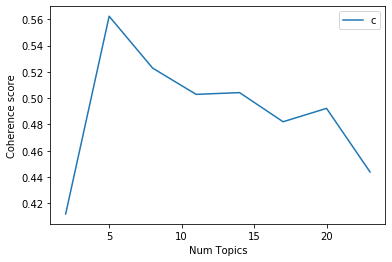

In [109]:
limit=25; start=2; step=3;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['tokenized_ingredients'], start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

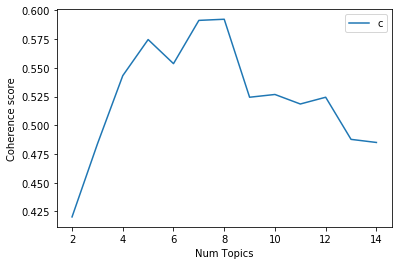

In [112]:
limit=15; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['tokenized_ingredients'], start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()